In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [120]:
gestures = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9
]
num_samples = 75
num_gestures = len(gestures)

one_hot = np.eye(len(gestures))

fulldata = pd.DataFrame(columns = ['aX','aY','aZ','gX','gY','gZ'])
formatdata = pd.DataFrame()
labels = []

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        filepath = 'test_{0}_{1}.csv'.format(gesture, i)
        data = pd.read_csv(filepath, index_col=False)
        
        data['aX'] = (data['aX'] + 4*9.81) / (2*4*9.81)
        data['aY'] = (data['aY'] + 4*9.81) / (2*4*9.81)
        data['aZ'] = (data['aZ'] + 4*9.81) / (2*4*9.81)
        data['gX'] = (data['gX'] + 7.5) / (2*7.5)
        data['gY'] = (data['gY'] + 7.5) / (2*7.5)
        data['gZ'] = (data['gZ'] + 7.5) / (2*7.5)
        
        fulldata = fulldata.append(data)
        dataf = data.to_numpy().flatten().tolist()
        formatdata[idx*num_samples+i-1] = dataf
        label = one_hot[idx]
        labels.append(label)

formatdata = formatdata.transpose().to_numpy()
labels = np.array(labels)


In [237]:
127500/10/250

51.0

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)


In [134]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2048, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [135]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,

)
history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))



Epoch 1/600
9/9 [==============================] - 2s 227ms/step - loss: 3.5576 - categorical_accuracy: 0.0821 - val_loss: 2.5028 - val_categorical_accuracy: 0.1062
Epoch 2/600
9/9 [==============================] - 2s 181ms/step - loss: 2.3747 - categorical_accuracy: 0.0992 - val_loss: 2.3127 - val_categorical_accuracy: 0.1150
Epoch 3/600
9/9 [==============================] - 2s 170ms/step - loss: 2.3181 - categorical_accuracy: 0.0973 - val_loss: 2.3028 - val_categorical_accuracy: 0.1327
Epoch 4/600
9/9 [==============================] - 2s 167ms/step - loss: 2.2930 - categorical_accuracy: 0.1088 - val_loss: 2.2788 - val_categorical_accuracy: 0.1062
Epoch 5/600
9/9 [==============================] - 2s 187ms/step - loss: 2.2360 - categorical_accuracy: 0.2080 - val_loss: 2.1860 - val_categorical_accuracy: 0.2212
Epoch 6/600
9/9 [==============================] - 2s 166ms/step - loss: 2.0939 - categorical_accuracy: 0.2385 - val_loss: 2.2575 - val_categorical_accuracy: 0.1504
Epoch 7/60

9/9 [==============================] - 2s 231ms/step - loss: 0.8248 - categorical_accuracy: 0.7099 - val_loss: 1.1575 - val_categorical_accuracy: 0.6018
Epoch 51/600
9/9 [==============================] - 2s 224ms/step - loss: 0.7814 - categorical_accuracy: 0.7366 - val_loss: 1.0243 - val_categorical_accuracy: 0.6460
Epoch 52/600
9/9 [==============================] - 2s 213ms/step - loss: 0.7277 - categorical_accuracy: 0.7252 - val_loss: 1.0877 - val_categorical_accuracy: 0.6726
Epoch 53/600
9/9 [==============================] - 2s 180ms/step - loss: 0.6863 - categorical_accuracy: 0.7538 - val_loss: 0.9532 - val_categorical_accuracy: 0.6637
Epoch 54/600
9/9 [==============================] - 2s 179ms/step - loss: 0.6336 - categorical_accuracy: 0.7672 - val_loss: 1.0187 - val_categorical_accuracy: 0.6726
Epoch 55/600
9/9 [==============================] - 2s 197ms/step - loss: 0.5595 - categorical_accuracy: 0.7977 - val_loss: 0.8483 - val_categorical_accuracy: 0.7434
Epoch 56/600
9/9 

9/9 [==============================] - 2s 177ms/step - loss: 0.5478 - categorical_accuracy: 0.8187 - val_loss: 0.7548 - val_categorical_accuracy: 0.7876
Epoch 100/600
9/9 [==============================] - 2s 178ms/step - loss: 0.6216 - categorical_accuracy: 0.7767 - val_loss: 0.7467 - val_categorical_accuracy: 0.7876
Epoch 101/600
9/9 [==============================] - 2s 187ms/step - loss: 0.5243 - categorical_accuracy: 0.8149 - val_loss: 0.9820 - val_categorical_accuracy: 0.6903
Epoch 102/600
9/9 [==============================] - 2s 228ms/step - loss: 0.6173 - categorical_accuracy: 0.7882 - val_loss: 0.7300 - val_categorical_accuracy: 0.7876
Epoch 103/600
9/9 [==============================] - 2s 211ms/step - loss: 0.3718 - categorical_accuracy: 0.8817 - val_loss: 0.8451 - val_categorical_accuracy: 0.7522
Epoch 104/600
9/9 [==============================] - 2s 210ms/step - loss: 0.3264 - categorical_accuracy: 0.8893 - val_loss: 0.6878 - val_categorical_accuracy: 0.7965
Epoch 105/60

9/9 [==============================] - 1s 156ms/step - loss: 0.1041 - categorical_accuracy: 0.9618 - val_loss: 0.7443 - val_categorical_accuracy: 0.8496
Epoch 149/600
9/9 [==============================] - 2s 170ms/step - loss: 0.1902 - categorical_accuracy: 0.9332 - val_loss: 1.1026 - val_categorical_accuracy: 0.7434
Epoch 150/600
9/9 [==============================] - 2s 169ms/step - loss: 0.2949 - categorical_accuracy: 0.9027 - val_loss: 1.2185 - val_categorical_accuracy: 0.6991
Epoch 151/600
9/9 [==============================] - 1s 163ms/step - loss: 0.2319 - categorical_accuracy: 0.9027 - val_loss: 0.8329 - val_categorical_accuracy: 0.7876
Epoch 152/600
9/9 [==============================] - 2s 187ms/step - loss: 0.2096 - categorical_accuracy: 0.9351 - val_loss: 0.7530 - val_categorical_accuracy: 0.8230
Epoch 153/600
9/9 [==============================] - 2s 193ms/step - loss: 0.1915 - categorical_accuracy: 0.9313 - val_loss: 0.8327 - val_categorical_accuracy: 0.7876
Epoch 154/60

4/4 [==============================] - 0s 25ms/step - loss: 0.3801 - categorical_accuracy: 0.9204


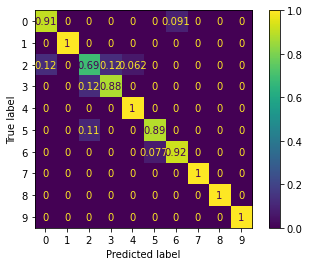

In [136]:
model.evaluate(X_test, y_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = np.round(model.predict(X_test), decimals=3)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = np.where(y_test == 1)[1]

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Try out different network sizes

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

hyperparameters = pd.DataFrame()

validation = []
for i in range(1,11):

    model = None
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(2048, activation='relu')) # relu is used for performance
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001, # minimium amount of change to count as an improvement
        patience=25, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

    history = model.fit(X_train, y_train, 
                        epochs=600,
                        batch_size=64,
                        callbacks=[early_stopping],
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    validation.append(model.evaluate(X_test, y_test))

np.average(validation, axis=0)


4/4 [==============================] - 0s 11ms/step - loss: 0.5973 - categorical_accuracy: 0.8407


array([0.52664173, 0.86814159])

## Hyperparameter Optimization

In [274]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

hyperparameters = pd.DataFrame()
for n in range(4,9):
    validation = []
    for i in range(1,11):
        
        model = None
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(2048, activation='relu')) # relu is used for performance
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
        model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

        early_stopping = callbacks.EarlyStopping(
            min_delta=0.0001, # minimium amount of change to count as an improvement
            patience=25, # how many epochs to wait before stopping
            restore_best_weights=True,
        )

        X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

        history = model.fit(X_train, y_train, 
                            epochs=600,
                            batch_size=2**n,
                            callbacks=[early_stopping],
                            validation_data=(X_val, y_val),
                            verbose=0)
        print((n-4)*10+i)
        validation.append(model.evaluate(X_test, y_test))
        
    hyperparameters[2**n] = np.average(validation, axis=0)
    


1
3/3 [==============================] - 0s 10ms/step - loss: 0.6501 - categorical_accuracy: 0.8052
2
3/3 [==============================] - 0s 9ms/step - loss: 0.3955 - categorical_accuracy: 0.8571
3
3/3 [==============================] - 0s 9ms/step - loss: 0.2367 - categorical_accuracy: 0.9091
4
3/3 [==============================] - 0s 10ms/step - loss: 0.6304 - categorical_accuracy: 0.8052
5
3/3 [==============================] - 0s 9ms/step - loss: 0.9463 - categorical_accuracy: 0.7143
6
3/3 [==============================] - 0s 9ms/step - loss: 1.0883 - categorical_accuracy: 0.7532
7
3/3 [==============================] - 0s 11ms/step - loss: 0.6646 - categorical_accuracy: 0.7662
8
3/3 [==============================] - 0s 10ms/step - loss: 0.4035 - categorical_accuracy: 0.9091
9
3/3 [==============================] - 0s 10ms/step - loss: 0.7413 - categorical_accuracy: 0.7662
10
3/3 [==============================] - 0s 8ms/step - loss: 0.4451 - categorical_accuracy: 0.8961
11
3

In [275]:
hyperparameters

,16,32,64,128,256
0,0.620182,0.618816,0.490793,0.617349,0.640195
1,0.818182,0.822078,0.859740,0.824675,0.820779


## Train model on full data

In [96]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2048, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
)

X_train, X_val, y_train, y_val = train_test_split(formatdata, labels, test_size=0.2)

history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val),
                    verbose=1)
